In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from torch import nn
from collections import defaultdict

# Data loading and Cleaning

In [3]:
path = Path('/home/suze/seed_images/Data_for_ML_Test/test_model/Belinda_test')
path.ls()

[PosixPath('/home/suze/seed_images/Data_for_ML_Test/test_model/Belinda_test/NewLabels'),
 PosixPath('/home/suze/seed_images/Data_for_ML_Test/test_model/Belinda_test/Images'),
 PosixPath('/home/suze/seed_images/Data_for_ML_Test/test_model/Belinda_test/models'),
 PosixPath('/home/suze/seed_images/Data_for_ML_Test/test_model/Belinda_test/valid.txt')]

In [4]:
path_img = path/'Images' #should later be provided through ini file
path_lbl = path/'NewLabels' #should later be provided through ini file
path_img
path_lbl

PosixPath('/home/suze/seed_images/Data_for_ML_Test/test_model/Belinda_test/NewLabels')

In [5]:
img_names=get_image_files(path_img)
img_names[:3]
lbl_names=get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/suze/seed_images/Data_for_ML_Test/test_model/Belinda_test/NewLabels/BM1_0833.tif'),
 PosixPath('/home/suze/seed_images/Data_for_ML_Test/test_model/Belinda_test/NewLabels/BM3_1364.tif'),
 PosixPath('/home/suze/seed_images/Data_for_ML_Test/test_model/Belinda_test/NewLabels/BM3_1785.tif')]

In [6]:
def get_mask(img):
    return (path_lbl)/img.name

In [7]:
"""function to filter out images that only contain background; used to calculate appropriate weights; 
function returns the images that also contain seed in a list"""
def filter_background(img_list):
    include=[]
    for img in img_list:
        mask = open_mask(get_mask(img))
        count_total=(torch.unique(mask.data, return_counts=True))
        if not count_total[0].tolist() == [0]:
            include.append(img)
    return include

In [8]:
"""function to filter out images that only contain background; used to filter in the data block API; 
function has to return a boolean
slow, every mask has to be opened to check the values"""
def check_back(img):
    mask = open_mask(get_mask(img))
    count_total=(torch.unique(mask.data, return_counts=True))
    if not count_total[0].tolist() == [0]:
        return True
    else:
        return False

In [9]:
#mask = open_mask(get_mask(img_names[300]))
#mask.data
#count_total=(torch.unique(mask.data, return_counts=True))
#count_total[0].tolist()
#len(img_names)

In [10]:
#include = filter_background(img_names)
#len(include)
#mask.show()

In [11]:
#img_list2
#img = open_image(img_names[1])
#img.show()
#src_size = np.array(mask.shape[1:])
#src_size,mask.data

In [12]:
def count_mask(img_list):
    img_list = filter_background(img_list)
    count_classes = defaultdict(int)
    for img in img_list:
        #return the occurence of every class in the mask for an image
        mask = open_mask(get_mask(img))
        count_total = torch.unique(mask.data, return_counts=True)
        classes=count_total[0].tolist()
        count_real=count_total[1].tolist()
        for x, y in zip(classes, count_real):
            count_classes[x] += y
    return count_classes

In [13]:
%time classes_count = count_mask(img_names)
classes_count
#slow for big sets, make faster?

CPU times: user 1h 5min 12s, sys: 4min 3s, total: 1h 9min 16s
Wall time: 2min 9s


defaultdict(int, {0: 1517113848, 1: 582329433, 2: 61204653, 3: 49913586})

In [14]:
#append occurences in a list 
#seems redundant
counts = []
for c in classes_count:
    counts.append(classes_count[c])
counts

[1517113848, 582329433, 61204653, 49913586]

In [15]:
weight_ratios =[min(counts)/x for x in counts]
weight_ratios

[0.032900356203195105, 0.08571365823441042, 0.8155194671228673, 1.0]

In [16]:
np.random.seed(42)
#slow with large data set
src = (SegmentationItemList.from_folder(path)
       .filter_by_func(check_back)
       .split_by_fname_file('valid.txt')
       .label_from_func(get_mask, classes=list(range(4))))

In [17]:
src

LabelLists;

Train: LabelList (3758 items)
x: SegmentationItemList
Image (3, 668, 864),Image (3, 668, 864),Image (3, 668, 864),Image (3, 668, 864),Image (3, 668, 864)
y: SegmentationLabelList
ImageSegment (1, 668, 864),ImageSegment (1, 668, 864),ImageSegment (1, 668, 864),ImageSegment (1, 668, 864),ImageSegment (1, 668, 864)
Path: /home/suze/seed_images/Data_for_ML_Test/test_model/Belinda_test;

Valid: LabelList (3568 items)
x: SegmentationItemList
Image (3, 678, 931),Image (3, 678, 931),Image (3, 678, 931),Image (3, 678, 931),Image (3, 678, 931)
y: SegmentationLabelList
ImageSegment (1, 678, 931),ImageSegment (1, 678, 931),ImageSegment (1, 678, 931),ImageSegment (1, 678, 931),ImageSegment (1, 678, 931)
Path: /home/suze/seed_images/Data_for_ML_Test/test_model/Belinda_test;

Test: None

In [19]:
%time data = (src.transform(get_transforms(), tfm_y=True, size=128).databunch(bs=8).normalize())

CPU times: user 24.6 s, sys: 3.53 s, total: 28.1 s
Wall time: 4.09 s


In [20]:
data

ImageDataBunch;

Train: LabelList (3758 items)
x: SegmentationItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: SegmentationLabelList
ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128)
Path: /home/suze/seed_images/Data_for_ML_Test/test_model/Belinda_test;

Valid: LabelList (3568 items)
x: SegmentationItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: SegmentationLabelList
ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128)
Path: /home/suze/seed_images/Data_for_ML_Test/test_model/Belinda_test;

Test: None

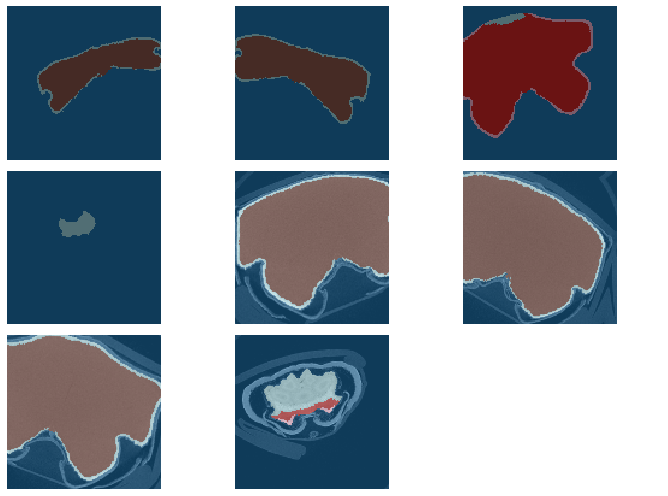

In [21]:
data.show_batch(4, figsize=(10,7))

# Learning

In [ ]:
#from Nikos
#based of fastai foreground_acc
def acc_seeds(input, target):
    target = target.squeeze(1)
    mask = target != 0 #not interested in background
    return (input.argmax(dim=1)[mask] == target[mask]).float().mean()

In [ ]:
metrics=acc_seeds
wd=1e-2

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [ ]:
#set class weights
class_weights=torch.FloatTensor(weight_ratios)
learn.crit = nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr = 1e-4

In [ ]:
lrs = slice(lr/100,lr)

In [ ]:
learn.fit_one_cycle(4, lr)

In [ ]:
learn.summary()

In [ ]:
#learn.save('stage-small_1')

In [ ]:
#learn.load('stage-small_1');

In [ ]:
#learn.unfreeze()

In [ ]:
#learn.fit_one_cycle(2, lrs)

In [ ]:
#learn.save('stage-small_2')

In [ ]:
#data_med = (src.transform(get_transforms(), tfm_y=True, size=256)
#       .databunch(bs=8)
#       .normalize())

In [ ]:
#learn = unet_learner(data_med, models.resnet34, metrics=metrics, wd=wd)
#learn.crit = nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
#learn.load('stage-small_2');

In [ ]:
#learn.unfreeze()

In [ ]:
#learn.fit_one_cycle(2, lrs)

In [ ]:
#learn.show_results()

In [ ]:
#learn.save('stage-med_1')

In [ ]:
#data_L = (src.transform(get_transforms(), tfm_y=True, size=300)
#       .databunch(bs=8)
#       .normalize())

In [ ]:
#learn.load('stage-med_1');

In [ ]:
#learn.unfreeze()

In [ ]:
#learn.fit_one_cycle(2, lrs)

In [ ]:
learn.show_results()

In [ ]:
from fastai.vision.interpret import *
interp = SegmentationInterpretation.from_learner(learn)
#interp = Interpretation.from_learner(learn)
#interp

In [ ]:
top_losses, top_idxs = interp.top_losses(sizes=(128,128))

In [ ]:
learn.data.classes

In [ ]:
mean_cm, single_img_cm = interp._generate_confusion()

In [ ]:
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

In [ ]:
# Look at single worst performing picture
i = top_idxs[0]
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")

In [ ]:
#need to fix type error: TypeError: object of type 'int' has no len()
#interp.show_xyz(i, sz=15)